# seq2seq模型——机器翻译

### 案例简介

seq2seq是神经机器翻译的主流框架，如今的商用机器翻译系统大多都基于其构建，在本案例中，我们将使用由NIST提供的中英文本数据训练一个简单的中英翻译系统，在实践中学习seq2seq的具体细节，以及了解机器翻译的基本技术。

### seq2seq模型

从根本上讲，机器翻译需要将输入序列（源语言中的单词）映射到输出序列（目标语言中的单词）。正如我们在课堂上讨论的那样，递归神经网络（RNN）可有效处理此类顺序数据。机器翻译中的一个重要难题是输入和输出序列之间没有一对一的对应关系。即，序列通常具有不同的长度，并且单词对应可以是不平凡的（例如，彼此直接翻译的单词可能不会以相同的顺序出现）。

为了解决这个问题，我们将使用一种更灵活的架构，称为seq2seq模型。该模型由编码器和解码器两部分组成，它们都是RNN。编码器将源语言中的单词序列作为输入，并输出RNN层的最终隐藏状态。解码器与之类似，除了它还具有一个附加的全连接层（带有softmax激活），用于定义翻译中下一个单词的概率分布。以此方式，解码器本质上用作目标语言的神经语言模型。关键区别在于，解码器将编码器的输出用作其初始隐藏状态，而不是零向量。

### 数据和代码

本案例使用了一个小规模的中英平行语料数据，并提供了一个简单的seq2seq模型实现，包括数据的预处理、模型的训练、以及简单的评测。

### 评分要求

分数由两部分组成，各占50%。第一部分得分为对于简单seq2seq模型的改进，并撰写实验报告，改进方式多样，下一小节会给出一些可能的改进方向。第二分部得分为测试数据的评测结果，我们将给出一个中文测试数据集（`test.txt`），其中每一行为一句中文文本，需要同学提交模型做出的对应翻译结果，助教将对于大家的提交结果统一机器评测，并给出分数。

### 改进方向

初级改进：
- 将RNN模型替换成GRU或者LSTM
- 使用双向的encoder获得更好的源语言表示
- 对于现有超参数进行调优，这里建议划分出一个开发集，在开发集上进行grid search，并且在报告中汇报开发集结果
- 引入更多的训练语料（如果尝试复杂模型，更多的训练数据将非常关键）

进阶改进：
- 使用注意力机制（注意力机制是一个很重要的NMT技术，建议大家优先进行这方面的尝试，具体有许多种变体，可以参考这个[综述](https://nlp.stanford.edu/pubs/emnlp15_attn.pdf)）
- 在Encoder部分，使用了字级别的中文输入，可以考虑加入分词的结果，并且将Encoder的词向量替换为预训练过的词向量，获得更好的性能

复杂改进：
- 使用beam search的技术来帮助更好的解码，对于beam-width进行调优
- 将RNN替换为Transformer模型，以及最新的改进变体

## 环境依赖

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import hanlp

from nltk.translate.bleu_score import sentence_bleu
import zhconv

如果使用GPU，则将下面的变量设为`True`。

In [2]:
USE_CUDA = True
print(USE_CUDA)

True


In [25]:
HanLP = hanlp.load(hanlp.pretrained.mtl.CLOSE_TOK_POS_NER_SRL_DEP_SDP_CON_ELECTRA_SMALL_ZH)
result = HanLP('商品和服务', tasks = 'tok')
print(result)

{
  "tok/fine": [
    "商品",
    "和",
    "服务"
  ]
}


filename = 'translate_train.txt'
with open(filename, 'r', encoding = 'utf8') as f:
    string = f.read()

#print(string)
data = string.split('\n')
print(data[0])
#data.pop()

## 读取数据

我们将读取目录下的`cn-eng.txt`文件，其中每一行是一个平行句对，例子如下：

```
我很冷。    I am cold.
```

### 对于单词进行编号

这里引入了两个特殊符号，“SOS”即“Start of sentence”和“EOS”即“End of sentence”。他们会加到输入文本的两端，以控制解码过程。

In [3]:
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5.!?，。？]+", r" ", s)
    return s

def read_sentence_file(filename):
    src_sentences_list = []
    trg_sentences_list = []
    src_vocab = []
    trg_vocab = []
    num = 0
    with open(filename[0], "r", encoding = 'utf8') as f:
        for line in f:
            num += 1
            if num%5000 == 0:
                print(num)
            src, trg = [normalize_string(s) for s in line.split('\t')]
            #src = zhconv.convert(src, 'zh-hans')
            #print(trg)
            temp = []
#             temp = HanLP(src, tasks = 'tok')['tok/fine']
            for w in src:
                if w != ' ':
                    temp.append(w)
                if w not in src_vocab:
                    src_vocab.append(w)
                    
            for w in temp:
                if w != ' ' and w not in src_vocab:
                    src_vocab.append(w)
            src_sentences_list.append(temp)
            
            temp = []
            for w in trg.split(' '):
                temp.append(w)
                if w not in trg_vocab:
                    trg_vocab.append(w)
            trg_sentences_list.append(temp)
            
        new_src_sentences_list, new_trg_sentences_list = [], []
        num = 0
        for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
            num += 1
            if num%5000 == 0:
                print(num)
            if len(src_sent) <= MAX_LENGTH and len(trg_sent) <= MAX_LENGTH:
                new_src_sentences_list.append(src_sent)
                new_trg_sentences_list.append(trg_sent)
        
    src_sentences_list = []
    trg_sentences_list = []
    with open(filename[1], "r", encoding = 'utf8') as f:
        for line in f:
            trg, src = [normalize_string(s) for s in line.split('\t')]
            #print(trg)
            #print(src)
            src = zhconv.convert(src, 'zh-hans')
            #print(trg)
            temp = []
#             temp = HanLP(src, tasks = 'tok')['tok/fine']
            for w in src:
                if w != ' ':
                    temp.append(w)
                if w not in src_vocab:
                    src_vocab.append(w)
                    
            for w in temp:
                if w != ' ' and w not in src_vocab:
                    src_vocab.append(w)
            src_sentences_list.append(temp)
            
            temp = []
            for w in trg.split(' '):
                temp.append(w)
                if w not in trg_vocab:
                    trg_vocab.append(w)
            trg_sentences_list.append(temp)
        
        num = 0
        for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
            num += 1
            if num%5000 == 0:
                print(num)
            if len(src_sent) <= MAX_LENGTH and len(trg_sent) <= MAX_LENGTH:
                new_src_sentences_list.append(src_sent)
                new_trg_sentences_list.append(trg_sent)
    
    src_vocab.append('<unk>')
    trg_vocab.append('<unk>')
    return new_src_sentences_list, new_trg_sentences_list, src_vocab, trg_vocab

MAX_LENGTH = 20
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50
src_sentences_list, trg_sentences_list, src_vocab, trg_vocab = read_sentence_file(('cn-eng.txt', 'translate_train.txt'))
#print(len(src_sentences_list))
#print(len(trg_sentences_list))
# src_extra_list = []
# trg_extra_list = []
# for dict_pair in data:
#     dict_pair = eval(dict_pair)
#     src = normalize_string(dict_pair['chinese'])
#     src_list = []
#     for w in src:
#         if w != ' ':
#             src_list.append(w)
#     if len(src_list) > MAX_LENGTH:
#     trg = normalize_string(dict_pair['english'])
#     #src_extra_list.append([w for w in src])
#     trg_extra_list.append([w for w in trg.split(' ')])

# src_sentences_list = src_sentences_list + src_extra_list
# trg_sentences_list = trg_sentences_list + trg_extra_list

train_src_sentences_list = src_sentences_list[:len(src_sentences_list)//100*95]
train_trg_sentences_list = trg_sentences_list[:len(trg_sentences_list)//100*95]
val_src_sentences_list = src_sentences_list[len(src_sentences_list)//100*95:]
val_trg_sentences_list = trg_sentences_list[len(trg_sentences_list)//100*95:]
# for src_sent, trg_sent in zip(val_src_sentences_list, val_trg_sentences_list):
#     if src_sent in train_src_sentences_list or trg_sent in train_trg_sentences_list:
#         val_src_sentences_list.remove(src_sent)
#         val_trg_sentences_list.remove(trg_sent)

length = [len(sent) for sent in train_src_sentences_list]

print(train_src_sentences_list[-1])
print(len(val_src_sentences_list))

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
5000
10000
['继', '续', '看']
5063


### 文本预处理

丢弃除了中文、字母和常用标点之外的符号。

读取平行语料，并进行清理。

### 过滤句子

样例为了加快训练，只保留了不长于10个单词的句对，真正实验中将更多数据考虑进来可能获得更好的效果。

处理数据的全过程：

- 读取数据，每一行分别处理，将其转换成句对
- 对于文本进行处理，过滤无用符号
- 根据已有文本对于单词进行编号，构建符号到编号的映射


In [4]:
from torch.utils import data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

class MTDataset(data.Dataset):
    def __init__(self, src_sentences, src_vocab, trg_sentences, trg_vocab, sampling=1.):
        self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
        self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]
        
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        
        self.max_src_seq_length = MAX_LENGTH+2   # max length plus eos and sos
        self.max_trg_seq_length = MAX_LENGTH+2

        self.src_v2id = {v : i for i, v in enumerate(src_vocab)}
        self.src_id2v = {val : key for key, val in self.src_v2id.items()}
        self.trg_v2id = {v : i for i, v in enumerate(trg_vocab)}
        self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, index):
        src_sent = self.src_sentences[index]
        src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
        src_id = []
        for w in src_sent:
            if w not in self.src_vocab:
                w = '<UNK>'
            src_id.append(self.src_v2id[w])
        src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_src_seq_length - src_len))

        trg_sent = self.trg_sentences[index]
        trg_len = len(trg_sent) + 2
        trg_id = []
        for w in trg_sent:
            if w not in self.trg_vocab:
                w = '<UNK>'
            trg_id.append(self.trg_v2id[w])
        trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_trg_seq_length - trg_len))

        return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## 将文本数据转换为张量

为了训练，我们需要将句子变成神经网络可以理解的东西（数字）。每个句子将被分解成单词，然后变成张量，其中每个单词都被索引替换（来自之前的Lang索引）。在创建这些张量时，我们还将附加EOS令牌以表示该句子已结束。

![](https://i.imgur.com/LzocpGH.png)

In [5]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    if lang.name == 'cn':
        #sentence_list = HanLP(sentence, tasks = 'tok')['tok/fine'] 
        return [lang.word2index[word] for word in sentence]
    else:
        return [lang.word2index[word] for word in sentence.split(' ')]
    
def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = torch.LongTensor(indexes).view(-1, 1)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# 组件模型

## 编码器

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout = 0.):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout)
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        
    def forward(self, inputs, lengths):
        # Note: we run this all at once (over the whole input sequence)
        pack_pad = pack_padded_sequence(self.dropout(self.embedding(inputs)), lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, finals = self.rnn(pack_pad)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True, total_length = inputs.size(1))
        return outputs, finals

    def init_hidden(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

In [7]:
class EncoderLSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, num_layers=2, bidirection = True, dropout=0.5):
        super(EncoderLSTM, self).__init__()
        
        self.input_size = input_size
        #print(input_size)
        #self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.bidirection = bidirection
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True,
                      dropout=dropout, bidirectional=self.bidirection)
        
        self.bi_linear = nn.Linear(2*hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs, lengths):
        pack_pad = pack_padded_sequence(self.dropout(self.embedding(inputs)), lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, finals = self.gru(pack_pad)
        outputs, _ = pad_packed_sequence(outputs, batch_first=True, total_length = inputs.size(1))
        
        if self.bidirection:
            forward = finals[0:list(finals.size())[0]:2]
            backward = finals[1:list(finals.size())[0]:2]
            finals = torch.cat([forward, backward], dim=2)
            #print('final after')
            #print(finals.size())
            finals = self.bi_linear(finals)
            outputs = self.bi_linear(outputs)
        
        return outputs, finals

    def init_hidden(self):
        # Initialize hidden and memory states.
        if self.bidirection == True:
            return torch.zeros(self.num_layers*2, 1, self.hidden_size)
        else:
            return torch.zeros(self.num_layers, 1, self.hidden_size)

## 解码器

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inputs, hidden):
        # Note: we run this one step at a time  
        #hidden = hidden[-1].unsqueeze(1)
        embed_input = self.dropout(self.embedding(inputs))
        #print(embed_input.size())
        #print(hidden.size())
        rnn_output, hidden = self.rnn(embed_input, hidden)

        #rnn_output = rnn_output.squeeze(0)
        #output = F.log_softmax(self.out(rnn_output))

        return rnn_output, hidden

In [9]:
class BahAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.q_weight = nn.Linear(hidden_size, hidden_size, bias=False)
        self.k_weight = nn.Linear(hidden_size, hidden_size, bias=False)
        #self.va = nn.Linear(hidden_size, 1, bias=False)
        self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.att_weight = None
        
    def forward(self, q, k, mask):
        """
        q: decoder hidden
        k: encoder outputs
        v: encoder outputs
        """
        #q = q.unsqueeze(1)
        #q_linear = nn.Linear(q.size(2), self.hidden_size).cuda()
        #k_linear = nn.Linear(k.size(2), self.hidden_size).cuda()
        #print(list(q_p.size()))
        #k_p = self.k_weight(k)
        #print(list(k.size()))
        combine = torch.tanh(self.q_weight(q) + self.k_weight(k))
        energy = torch.matmul(self.v, torch.transpose(combine, 1, 2))
        #energy = torch.bmm(combine, torch.transpose(v, 1, 2))
        energy.data.masked_fill_(mask == False, -float('inf'))
        att_weight = F.softmax(energy, dim=-1)
        self.att_weight = att_weight
        context = torch.bmm(att_weight, k)
        return context

'''
AttentionDecoder
'''

class AttentionDecoder(nn.Module):
    """An attention-based RNN decoder."""

    def __init__(self, output_size, hidden_size, num_layers, feed_ratio = 0.5, dropout=0., attention = None):
        """
          Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
        - `attention`: this is your self-defined Attention object. You can
            either define an individual class for your Attention and pass it
            here or leave `attention` as None and just implement everything
            here.
        """
        super(AttentionDecoder, self).__init__()

        ### Your code here!
        self.hidden_size = hidden_size
        #self.input_size = input_size
        self.dropout_p = dropout
        self.feed_ratio = feed_ratio
        self.output_size = output_size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attention = attention
        
        #self.input_hidden = nn.Linear(input_size, hidden_size)
        self.lstm_attn = nn.LSTM(hidden_size*2, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        #self.output1 = nn.Linear(hidden_size, hidden_size)
        #self.output2 = nn.Linear(hidden_size*3, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    
    def forward(self, inputs, hidden, encoder_outputs, encoder_final, src_mask):

        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        if self.attention != None:
            context = self.attention(hidden[-1].unsqueeze(1), encoder_outputs, src_mask)
            embed_input = self.embedding(inputs)
            #print(embed_input.size())
            lstm_input = torch.cat([context, self.dropout(embed_input)], dim = -1)
            #print('hidden size')
            #print(hidden[0].size())
            lstm_output, (hidden, cell) = self.lstm_attn(lstm_input, (hidden, hidden))
        else:
            embed_input = self.embedding(inputs)
            lstm_output, (hidden, cell) = self.lstm(embed_input, (hidden, hidden))
        #output = self.out(lstm_output)
        

        #output_prob = F.log_softmax(output, dim = -1)

        #return output_prob, lstm_output, hidden
        return lstm_output, hidden

    def init_hidden(self, encoder_final):
        """Use encoder final hidden state to initialize decoder's first hidden
        state."""
        #decoder_init_hiddens = None
        ### Your code here!

        if encoder_final != None:
            return torch.tanh(encoder_final)
        else:
            return None

In [10]:
class EncoderDecoder(nn.Module):
    """A Encoder-Decoder architecture with attention.
    """
    def __init__(self, encoder, decoder, feed_ratio, generator):
        """
        Inputs:
          - `encoder`: an `Encoder` object.
          - `decoder`: an `AttentionDecoder` object.
          - `src_embed`: an nn.Embedding object representing the lookup table for
              input (source) sentences.
          - `trg_embed`: an nn.Embedding object representing the lookup table for
              output (target) sentences.
          - `generator`: a `Generator` object. Essentially a linear mapping. See
              the next code cell.
        """
        super(EncoderDecoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.feed_ratio = feed_ratio
        self.generator = generator

    def forward(self, src_ids, trg_ids, src_lengths, max_len = MAX_LENGTH+2):
        """Take in and process masked source and tar get sequences.

        Inputs:
          `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of source sentences of word ids.
          `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of target sentences of word ids.
          `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
            sequence length of `src_ids`.

        Returns the decoder outputs, see the above cell.
        """
        ### Your code here!
        # You can refer to `EncoderDecoder` and extend from it.
        src_mask = (src_ids != 0).unsqueeze(1)
        encoder_outputs, encoder_final = self.encoder(src_ids, src_lengths)
        
        batch_size = src_ids.size()[0]
        decoder_input = torch.ones(batch_size, 1).fill_(SOS_INDEX).type_as(src_ids)
        #print(decoder_input.size())
        decoder_hidden = encoder_final
#         if USE_CUDA:
#             decoder_input = decoder_input.cuda()

        outputs = []
        for i in range(max_len-1):
            #print(hidden[-1].size())
            #print(hidden[-1].unsqueeze(1).size())
            #output_prob, decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs, encoder_final, src_mask)
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            feed_target = True if random.random() < self.feed_ratio else False
            if feed_target:
                decoder_input = trg_ids[:,i+1].unsqueeze(1)
            else:
                #print(decoder_output[:, -1].size())
                #print(decoder_output[:, -1].size())
                prob = self.generator(decoder_output[:, -1]).unsqueeze(1)
                _, next_word = torch.max(prob, dim = 2)
                decoder_input = next_word
                #print('topi')
                #print(topi.size())
                #decoder_input = topi.squeeze(2)
            
            outputs.append(decoder_output)
    
        #print(len(outputs))
        #print(outputs[0].size())
        outputs = torch.cat(outputs, dim = 1)
        return outputs

In [11]:
class EncoderAttentionDecoder(nn.Module):
    """A Encoder-Decoder architecture with attention.
    """
    def __init__(self, encoder, decoder, feed_ratio, generator):
        """
        Inputs:
          - `encoder`: an `Encoder` object.
          - `decoder`: an `AttentionDecoder` object.
          - `src_embed`: an nn.Embedding object representing the lookup table for
              input (source) sentences.
          - `trg_embed`: an nn.Embedding object representing the lookup table for
              output (target) sentences.
          - `generator`: a `Generator` object. Essentially a linear mapping. See
              the next code cell.
        """
        super(EncoderAttentionDecoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.feed_ratio = feed_ratio
        self.generator = generator

    def forward(self, src_ids, trg_ids, src_lengths, max_len = MAX_LENGTH+2):
        """Take in and process masked source and tar get sequences.

        Inputs:
          `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of source sentences of word ids.
          `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
            a batch of target sentences of word ids.
          `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
            sequence length of `src_ids`.

        Returns the decoder outputs, see the above cell.
        """
        ### Your code here!
        # You can refer to `EncoderDecoder` and extend from it.
        src_mask = (src_ids != 0).unsqueeze(1)
        encoder_outputs, encoder_final = self.encoder(src_ids, src_lengths)
        
        batch_size = src_ids.size()[0]
        decoder_input = torch.ones(batch_size, 1).fill_(SOS_INDEX).type_as(src_ids)
        #print(decoder_input.size())
        decoder_hidden = encoder_final
#         if USE_CUDA:
#             decoder_input = decoder_input.cuda()

        outputs = []
        for i in range(max_len-1):
            #print(hidden[-1].size())
            #print(hidden[-1].unsqueeze(1).size())
            #output_prob, decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs, encoder_final, src_mask)
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs, encoder_final, src_mask)
            feed_target = True if random.random() < self.feed_ratio else False
            if feed_target:
                decoder_input = trg_ids[:,i+1].unsqueeze(1)
            else:
                #print(decoder_output[:, -1].size())
                prob = self.generator(decoder_output[:, -1]).unsqueeze(1)
                _, next_word = torch.max(prob, dim = 2)
                decoder_input = next_word
                #print('topi')
                #print(topi.size())
                #decoder_input = topi.squeeze(2)
            
            outputs.append(decoder_output)
    
        #print(len(outputs))
        #print(outputs[0].size())
        outputs = torch.cat(outputs, dim = 1)
        return outputs

In [12]:
batch_size = 128
#embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 200  # RNN hidden size.
dropout = 0.2
num_layers = 3
bidirection = True
feed_ratio = 0.2
learning_rate = 2e-4
clipping_value = 2 
num_epochs = 60
MAX_LENGTH = 20
early_stop = 5


train_set = MTDataset(train_src_sentences_list, src_vocab,
                      train_trg_sentences_list, trg_vocab, sampling=1.)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab,
                    val_trg_sentences_list, trg_vocab, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8, shuffle=False)

# 训练

## 一次训练迭代

为了训练，我们首先通过编码器逐字运行输入语句，并跟踪每个输出和最新的隐藏状态。接下来，为解码器提供解码器的最后一个隐藏状态作为其第一隐藏状态，并向其提供`<SOS>`作为其第一输入。从那里开始，我们迭代地预测来自解码器的下一个单词。
    
### Teacher Forcing 和 Scheduled Sampling

"Teacher Forcing"指的是每次都基于完全准确的上文进行解码，这样训练模型收敛很快，但是会造成实际场景和训练场景有较大差别，因为实际场景上文也都是模型预测的，可能不准确，具体细节可参考[论文](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf)。

观察Teacher Forcing的网络的输出，我们可以看到该网络语法连贯，但是偏离正确的翻译。可以将其为学会了如何听老师的指示，而未学习如何独自冒险。

解决强迫教师问题的方法称为“计划抽样”（[Scheduled Sampling](https://arxiv.org/abs/1506.03099)），它在训练时仅在使用目标值和预测值之间进行切换。我们将在训练时随机选择,有时我们将使用真实目标作为输入（忽略解码器的输出），有时我们将使用解码器的输出。

In [13]:
import math


class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None, c_value = None, model = None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        self.clipping_value = c_value
        self.model = model

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:  # training mode
            loss.backward()    
            ########################## clip
            torch.nn.utils.clip_grad_norm(self.model.parameters(), self.clipping_value)
            ##########################
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
    """Standard Training and Logging Function"""

    total_tokens = 0
    total_loss = 0

    for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
        # We define some notations here to help you understand the loaded tensor
        # shapes:
        #   `B`: batch size
        #   `T`: max sequence length of source sentences
        #   `L`: max sequence length of target sentences; due to our preprocessing
        #        in the beginning, `L` == `T` == 50
        # An example of `src_ids_BxT` (when B = 2):
        #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
        #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
        # The corresponding `src_lengths_B` would be [47, 49].
        # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.

        src_ids_BxT = src_ids_BxT.to(device)
        src_lengths_B = src_lengths_B.to(device)
        trg_ids_BxL = trg_ids_BxL.to(device)
        del trg_lengths_B   # unused

        output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B)
        #print(output.size())
        #print(trg_ids_BxL[:,1:].size())
        loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                            norm=src_ids_BxT.size(0))
        total_loss += loss
        total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

        if model.training and i % print_every == 0:
            print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

    return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every, clipping_value, early_stop):
    # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
    # computing the loss.
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Keep track of dev ppl for each epoch.
    dev_ppls = []
    min_ppls = float('inf')
    stop = 0
    for epoch in range(num_epochs):
        print("Epoch", epoch)

        model.train()
        train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                              loss_compute=SimpleLossCompute(model.generator, criterion, optim, clipping_value, model), print_every=print_every)

        model.eval()
        with torch.no_grad():      
            dev_ppl = run_epoch(data_loader=val_data_loader, model=model, loss_compute=SimpleLossCompute(model.generator, criterion, None, None), print_every=print_every)
            print("Validation perplexity: %f" % dev_ppl)
            if dev_ppl < min_ppls:
                min_ppls = dev_ppl
                stop = 0
            else:
                stop +=1
            
            dev_ppls.append(dev_ppl)
            
            if stop > early_stop:
                break
        
    return dev_ppls

下面是用于辅助输出训练情况的函数

Epoch 0


/home/mingye/.conda/envs/opence/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/mingye/.conda/envs/opence/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch Step: 0 Loss: 85.156792
Epoch Step: 100 Loss: 47.402527
Epoch Step: 200 Loss: 46.616879
Epoch Step: 300 Loss: 44.978535
Epoch Step: 400 Loss: 45.718906
Epoch Step: 500 Loss: 44.317425
Epoch Step: 600 Loss: 47.137100
Epoch Step: 700 Loss: 42.280804
Validation perplexity: 134.147590
Epoch 1
Epoch Step: 0 Loss: 44.436398
Epoch Step: 100 Loss: 39.273205
Epoch Step: 200 Loss: 41.056782
Epoch Step: 300 Loss: 42.482124
Epoch Step: 400 Loss: 45.122105
Epoch Step: 500 Loss: 41.393913
Epoch Step: 600 Loss: 41.293709
Epoch Step: 700 Loss: 39.675114
Validation perplexity: 94.182579
Epoch 2
Epoch Step: 0 Loss: 41.052776
Epoch Step: 100 Loss: 41.820160
Epoch Step: 200 Loss: 41.632366
Epoch Step: 300 Loss: 42.706738
Epoch Step: 400 Loss: 39.876827
Epoch Step: 500 Loss: 40.789352
Epoch Step: 600 Loss: 41.988914
Epoch Step: 700 Loss: 42.029194
Validation perplexity: 73.178903
Epoch 3
Epoch Step: 0 Loss: 36.936195
Epoch Step: 100 Loss: 40.452415
Epoch Step: 200 Loss: 41.109303
Epoch Step: 300 Loss

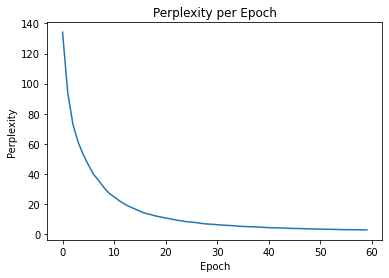

In [14]:
import matplotlib.pyplot as plt

class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

attention = BahAttention(hidden_size)
attn_seq2seq = EncoderAttentionDecoder(
  encoder=EncoderLSTM(len(src_vocab), hidden_size, num_layers, bidirection, dropout),
  decoder=AttentionDecoder(len(trg_vocab), hidden_size, num_layers, feed_ratio, dropout, attention), 
  #decoder=AttentionDecoder(len(trg_vocab), hidden_size, num_layers, feed_ratio, dropout), 
  feed_ratio = feed_ratio,
  generator=Generator(hidden_size, len(trg_vocab))).to(device)

pure_seq2seq = EncoderDecoder(
  encoder=EncoderRNN(len(src_vocab), hidden_size),
  decoder=DecoderRNN(len(trg_vocab), hidden_size), 
  feed_ratio = feed_ratio,
  generator=Generator(hidden_size, len(trg_vocab))).to(device)


attn_dev_ppls = train(attn_seq2seq, num_epochs, learning_rate, 100, clipping_value, early_stop)

#pure_dev_ppls = train(pure_seq2seq, num_epochs, learning_rate, 100, clipping_value, early_stop)

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)


#torch.save(attn_seq2seq, 'seq2seq.model')
torch.save(pure_seq2seq, 'seq2seq_pure.model')
plot_perplexity(attn_dev_ppls)

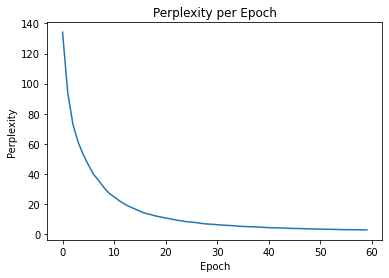

In [15]:
import matplotlib.pyplot as plt

#plot_perplexity(pure_dev_ppls)
plot_perplexity(attn_dev_ppls)

## 进行训练

以下设置变量用于绘制图标和跟踪进度：

要进行实际训练，我们会多次调用训练函数，并在进行过程中打印中间信息。

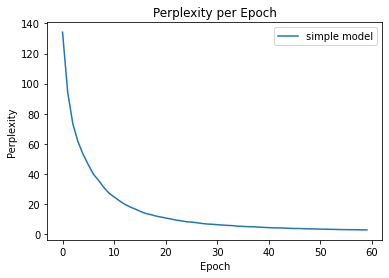

In [16]:
plt.title("Perplexity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
#plt.plot(pure_dev_ppls, label='pure model')
#plt.plot(attn_dev_ppls, label='attn model')
plt.plot(attn_dev_ppls, label='simple model')
plt.legend(loc = 'upper right')

def greedy_decode(model, src_ids, src_lengths, max_len, pad_index = 0):
    """Greedily decode a sentence for EncoderDecoder."""

    with torch.no_grad():
        encoder_outputs, encoder_final = model.encoder(src_ids, src_lengths)
        decoder_input = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

    output = []
    hidden = None
    decoder_hidden = encoder_final

    for i in range(max_len):
        with torch.no_grad():
            if model == pure_seq2seq:
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
            if model == attn_seq2seq:
                #print(decoder_input)
                src_mask = (src_ids != pad_index).unsqueeze(1)
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden, encoder_outputs, encoder_final, src_mask)
            
            prob = model.generator(decoder_output[:, -1])
            
        _, next_word = torch.max(prob, dim=1)
        #print(prob_val)
        next_word = next_word.data.item()
        output.append(next_word)
        decoder_input = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

    output = np.array(output)
    #print(output)

    # Cut off everything starting from </s>.
    first_eos = np.where(output == EOS_INDEX)[0]
    if len(first_eos) > 0:
        output = output[:first_eos[0]]

    #print(np.array(attn_scores))
    return output
  

def lookup_words(x, vocab):
    return [vocab[i] for i in x]

In [43]:
def beam_decode(model, src_ids, src_lengths, max_len, beam_width, pad_index = 0):
    """Greedily decode a sentence for EncoderDecoder."""

    with torch.no_grad():
        encoder_outputs, encoder_final = model.encoder(src_ids, src_lengths)
        decoder_input = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

    output = []
    hidden = None
    decoder_hidden = encoder_final
    final_candidates = []
    candidates = [(0, decoder_input, decoder_hidden, [])]
    
    for i in range(max_len):
        if beam_width == 0:
            break
        with torch.no_grad():
            next_candidates = []
            for log_p, decoder_input, decoder_hidden, words in candidates:
                #if model == attn_seq2seq:
                src_mask = (src_ids != pad_index).unsqueeze(1)
                decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden, encoder_outputs, encoder_final, src_mask)
                #print(decoder_output[:, -1].size())
                prob = model.generator(decoder_output[:, -1])
                topv, topi = prob.data.topk(beam_width)
                #print(topi)
                #print(torch.max(prob, dim=1))
                topv = torch.add(topv, log_p)

                for i in range(beam_width):
                    if words != [] and words[-1] == topi[0][i].data.item():
#                         topv[0][i] = topv[0][i]*2
                        continue
                    next_candidates.append([topv[0][i], topi[0][i], decoder_hidden, words + [topi[0][i].data.item()]])
            
            #print(next_candidates.size())
            next_candidates.sort(reverse = True)
            #print('sorted candidates')
            #print(next_candidates)
            #next_candidates = next_candidates[:beam_width]
            candidates = []
            for i in range(len(next_candidates)):
                if len(candidates) == beam_width:
                    break
                #first_eos = np.where(np.array(next_candidates[i][2]) == EOS_INDEX)[0]
                if EOS_INDEX == next_candidates[i][1]:
                    final_candidates.append([next_candidates[i][0], next_candidates[i][3]])
                    beam_width -= 1
                else:
                    next_candidates[i][1] = torch.ones(1, 1).type_as(src_ids).fill_(next_candidates[i][1].data.item())
                    candidates.append(next_candidates[i])
    
    max_log_p = -float('inf')
    best_decode = []
    for candidate in final_candidates:
        #print(candidate[2])
        candidate[0] = candidate[0]/len(candidate[1])
        #print(candidate[0])
        if candidate[0] > max_log_p:
            max_log_p = candidate[0]
            best_decode = candidate[1]
    
    best_decode = np.array(best_decode)
    #print(best_decode)
    first_eos = np.where(best_decode == EOS_INDEX)[0]
    #print(first_eos[0])
    if len(first_eos) > 0:
        best_decode = best_decode[:first_eos[0]]
        
    return best_decode

In [44]:
beam_width = 5

def print_examples(model, data_loader, n=5,
                   max_len=MAX_LENGTH, 
                   src_vocab_set=src_vocab, trg_vocab_set=trg_vocab):
    """Prints `n` examples. Assumes batch size of 1."""

    model.eval()
    
    for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
        pred = beam_decode(model, src_ids.to(device), src_lengths.to(device),
                               max_len, beam_width)
        
#         pred = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
#                                max_len)

        #preds.append(result)
        #weights.append(attn_scores)

        # remove <s>
        src_ids = src_ids[0, 1:]
        trg_ids = trg_ids[0, 1:]

        # remove </s> and <pad>
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
        trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

        src_w = lookup_words(src_ids, src_vocab_set)
        trg_w = lookup_words(trg_ids, trg_vocab_set)
        pred_w = lookup_words(pred, trg_vocab_set)    
        
        if i > 30 and i < 50:
            print("Example #%d" % (i + 1))
            print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
            print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
            print("Pred: ", " ".join(lookup_words(pred, vocab=trg_vocab_set)))
        #print()

        if i >= 50:
            break
    
    return src_w, pred_w

In [ ]:
#import sacrebleu
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

def compute_BLEU(model, data_loader):
    bleu_score = []
    
    model.eval()
    
    mapping = {}
    for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
        src_ids = src_ids[0, 1:]
        trg_ids = trg_ids[0, 1:]
        
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
        trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]
        
        src_w = lookup_words(src_ids, src_vocab)
        trg_w = lookup_words(trg_ids, trg_vocab)
        
        src = " ".join(src_w)
        if src not in mapping:
            mapping[src] = [trg_w]
        else:
            mapping[src].append(trg_w)
            
    for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
        result = beam_decode(model, src_ids.to(device), src_lengths.to(device),
                               MAX_LENGTH, beam_width)
#         result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
#                                MAX_LENGTH)
        # remove <s>
        src_ids = src_ids[0, 1:]
        trg_ids = trg_ids[0, 1:]
        # remove </s> and <pad>
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
        trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]
        
        src_list = lookup_words(src_ids, vocab = src_vocab)
        pred_list = lookup_words(result, vocab=trg_vocab)
        targ_list = lookup_words(trg_ids, vocab=trg_vocab)
        
        src = " ".join(lookup_words(src_ids, vocab=src_vocab))
        pred = " ".join(lookup_words(result, vocab=trg_vocab))
        targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab))
        
        if src in mapping:
            bleu_score.append(sentence_bleu(mapping[src], pred_list))
        #bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)
        #bleu_score.append(sentence_bleu([targ_list], pred_list))
    return bleu_score


# test_set = MTDataset(test_src_sentences_list, src_vocab,
#                      test_trg_sentences_list, trg_vocab, sampling=1.)
# test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
#                                    shuffle=False)

example_set = MTDataset(val_src_sentences_list, src_vocab,
                        val_trg_sentences_list, trg_vocab)

example_data_loader = data.DataLoader(val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print('BLEU score: %f' % (np.mean(compute_BLEU(attn_seq2seq,
                                               example_data_loader))))

# print('BLEU score: %f' % (np.mean(compute_BLEU(pure_seq2seq,
#                                                example_data_loader))))

 30%|██▉       | 1495/5063 [03:22<07:09,  8.30it/s]

In [ ]:
print(lookup_words([14], trg_vocab))

In [39]:
src_w, pred_w = print_examples(attn_seq2seq, example_data_loader, 15, MAX_LENGTH)

Example #32
Src :  她 向 我 求 助 。
Trg :  she asked me for help .
Pred:  she asked me for help .
Example #33
Src :  我 想 我 今 晚 会 洗 澡 。
Trg :  i think i ll take a bath tonight .
Pred:  i think i ll take a bath tonight .
Example #34
Src :  我 努 力 地 平 息 他 们 不 断 加 温 的 争 执 。
Trg :  i tried very hard to put an end to their heated argument .
Pred:  i tried surprised to that to take rid of them of them .
Example #35
Src :  年 轻 人 伸 出 他 的 手 ， 接 着 我 和 他 握 了 手 。
Trg :  the young man put out his hand and i shook it .
Pred:  the man were his hand his hand to him out .
Example #36
Src :  月 光 真 美 。
Trg :  the moonlight is beautiful .
Pred:  the moonlight is really beautiful .
Example #37
Src :  我 差 点 大 声 笑 了 出 来 。
Trg :  i almost laughed out loud .
Pred:  i almost laughed out .
Example #38
Src :  汤 姆 是 不 是 麻 烦 事 很 多 ？
Trg :  is tom in a lot of trouble ?
Pred:  is tom any a lot of that ?
Example #39
Src :  我 收 集 很 多 邮 票 。
Trg :  i have a large collection of stamps .
Pred:  i have a lot of stamps .
Example #4

测试集翻译

In [71]:
import json

class TestDataset(data.Dataset):
    def __init__(self, src_sentences, src_vocab, sampling=1.):
        self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
        
        self.src_vocab = src_vocab
        
        self.max_src_seq_length = MAX_LENGTH+2   # max length plus eos and sos

        self.src_v2id = {v : i for i, v in enumerate(src_vocab)}
        self.src_id2v = {val : key for key, val in self.src_v2id.items()}

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, index):
        src_sent = self.src_sentences[index]
        src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
        src_id = []
        for w in src_sent:
            if w not in self.src_vocab:
                w = '<unk>'
            src_id.append(self.src_v2id[w])
        src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
                  (self.max_src_seq_length - src_len))

        return torch.tensor(src_id), src_len


test_src_sentences_list = []
test_src_vocab = []
with open('test.txt', "r", encoding = 'utf8') as f:
    for line in f:
        src = [normalize_string(s) for s in line]
        #src = zhconv.convert(src, 'zh-hans')
        #print(trg)
        temp = []
        for w in src:
            if w != ' ':
                temp.append(w)
            if w not in src_vocab:
                test_src_vocab.append(w)
        #if temp not in test_src_sentences_list:
        test_src_sentences_list.append(temp)

test_set = TestDataset(test_src_sentences_list, src_vocab, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8, shuffle=False)

def translate_test_examples(model, data_loader, n_print = 10, max_len=MAX_LENGTH,
                   src_vocab_set=test_src_vocab, trg_vocab_set=trg_vocab):
    """Prints `n` examples. Assumes batch size of 1."""

    model.eval()

    preds = []

    for i, (src_ids, src_lengths) in enumerate(data_loader):
        pred = beam_decode(model, src_ids.to(device), src_lengths.to(device), max_len, beam_width)

        #preds.append(result)
        #weights.append(attn_scores)

        # remove <s>
        src_ids = src_ids[0, 1:]

        # remove </s> and <pad>
        src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]

        src_w = " ".join(lookup_words(src_ids, vocab=src_vocab_set))
        #trg_w = lookup_words(trg_ids, trg_vocab_set)
        pred_w = " ".join(lookup_words(pred, vocab=trg_vocab_set))

        #print("Example #%d" % (i + 1))
        #print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
        #print("Pred: ", " ".join(lookup_words(pred, vocab=trg_vocab_set)))
        preds.append(pred_w)
        
        if i < n_print:
            print("Example #%d" % (i + 1))
            print("Pred: ", pred_w)

    return preds


preds = translate_test_examples(attn_seq2seq, test_data_loader, 10, MAX_LENGTH)
with open('test_results_beam1.txt', 'w', encoding = 'utf8') as outfile:
    json.dump(preds, outfile)

Example #1
Pred:  why so i not a good time i can study t study english ?
Example #2
Pred:  she helped me love her in her .
Example #3
Pred:  this bottle of yogurt isn t lactose .
Example #4
Pred:  this bottle of yogurt isn t lactose .
Example #5
Pred:  i can t help you .
Example #6
Pred:  i can t help you .
Example #7
Pred:  tom is not a good driver .
Example #8
Pred:  i can speak spanish putonghua and southwestern wu chinese wu mandarin .
Example #9
Pred:  this question is not that simple .
Example #10
Pred:  he can speak french but he can speak french .


In [ ]:
def beam_evaluate(sentence, encoder, decoder, beam_width, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    #target_variable = variable_from_sentence(input_lang, target)
    
    # Run through encoder
    #encoder_hidden = encoder.init_hidden()
    #encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    encoder_outputs, encoder_hidden = encoder(input_variable)
    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
    
    candidates = [(0, decoder_input, [])]
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    #decoded_words_idx = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    #log_p = 0
    # Run through decoder
    final_candidates = []
    for di in range(max_length):
        #if len(final_candidates) == beam_width or beam_width <= 0:
            #break
            
        next_candidates = []
        for log_p, decoder_input, words in candidates:
            #decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            for idx in range(output_lang.n_words):
                w = output_lang.index2word[idx]
                if w == 'SOS' or 'UNK':
                    continue
                elif w == 'EOS':
                    count = len(pairs)
                    decoder_output[0, idx] = decoder_output[0, idx]*count/1000
                else:
                    count = output_lang.word2count[w]
                    if count > 5000:
                        decoder_output[0, idx] = decoder_output[0, idx]*count/1000

            # Choose top word from output
            topv, topi = decoder_output.data.topk(beam_width)
            topv = torch.add(topv, log_p)
            for i in range(beam_width):
                #print(topi[0][i])
                word_i = output_lang.index2word[topi[0][i].item()]
                #print(word_i)
                next_candidates.append([topv[0][i], topi[0][i], words + [word_i]])
        
        next_candidates.sort(reverse = True)
        next_candidates = next_candidates[:beam_width]
        candidates = []
        for i in range(len(next_candidates)):
            if EOS_token == next_candidates[i][1] or di == max_length-1:
                beam_width -= 1
                final_candidates.append(next_candidates[i])
            else:
                next_candidates[i][1] = torch.LongTensor([[next_candidates[i][1]]])
                if USE_CUDA: next_candidates[i][1] = next_candidates[i][1].cuda()
                candidates.append(next_candidates[i])
        
#         # Next input is chosen word
#         decoder_input = torch.LongTensor([[ni]])
#         if USE_CUDA: decoder_input = decoder_input.cuda()
    
    max_log_p = -float('inf')
    best_decode = []
    for candidate in final_candidates:
        print(candidate[2])
        candidate[0] = candidate[0].item()/len(candidate[2])
        if candidate[0] > max_log_p:
            max_log_p = candidate[0]
            best_decode = candidate[2]
        
    return best_decode

#words = evaluate(pairs[1][0], encoder, decoder)

## 绘制训练loss

# 模型验证

随机选取一个句子进行验证。

In [ ]:
beam_width = 5
def evaluate_randomly(encoder, decoder):
    pair = random.choice(pairs)
    
    #output_words = beam_evaluate(pair[0], encoder, decoder, beam_width)
    output_words = beam_evaluate(pair[0], encoder, decoder, beam_width)
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [ ]:
for i in range(10):
    evaluate_randomly(encoder, decoder)

随机的验证只是一个简单的例子，为了能系统性的完成测试数据的翻译，这里仍需要实现一个新的函数。